In [1]:
import sys
sys.path.append('..')
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
import xarray as xr
import random as rd
import platform
%matplotlib inline

from model.convlstm import ConvLSTM
from tool.train_evaluate import Trainer, Evaluator
from tool.dataset import NetCDFDataset
from tool.utils import Util

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch import optim

Load specific variables for each dataset

In [3]:
%run dataset-variables.py

version = 1
dataset = ../data/dataset-ucar-1979-2015-seq5-ystep5.nc
input_size = 32
step = 5
learning rate = 0.001
param = {'layer_size': 2, 'kernel_size': 3, 'hidden_dim': 64}


In [4]:
util = Util('ConvLSTM', version=version, dataset=dataset)

os.environ["CUDA_VISIBLE_DEVICES"]='0'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

Seed

In [5]:
seed = 1000
np.random.seed(seed)
rd.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic=True

In [6]:
def init_seed(seed):
    np.random.seed(seed)

Hyperparameters

In [7]:
epochs = 50
batch_size = 50
validation_split = 0.2
test_split = 0.2
layer_size = param['layer_size']
kernel_size = param['kernel_size']
hidden_dim = param['hidden_dim']

Loading the dataset

In [8]:
ds = xr.open_mfdataset(dataset_file)
#ds = ds[dict(sample=slice(0,500))]

In [9]:
train_dataset = NetCDFDataset(ds, test_split=test_split, validation_split=validation_split)
val_dataset = NetCDFDataset(ds, test_split=test_split, validation_split=validation_split, is_validation=True)
test_dataset = NetCDFDataset(ds, test_split=test_split, validation_split=validation_split, is_test=True)

In [10]:
print('[X_train] Shape:', train_dataset.X.shape)
print('[y_train] Shape:', train_dataset.y.shape)
print('[X_val] Shape:', val_dataset.X.shape)
print('[y_val] Shape:', val_dataset.y.shape)
print('[X_test] Shape:', test_dataset.X.shape)
print('[y_test] Shape:', test_dataset.y.shape)

[X_train] Shape: torch.Size([32427, 1, 5, 32, 32])
[y_train] Shape: torch.Size([32427, 1, 5, 32, 32])
[X_val] Shape: torch.Size([10810, 1, 5, 32, 32])
[y_val] Shape: torch.Size([10810, 1, 5, 32, 32])
[X_test] Shape: torch.Size([10810, 1, 5, 32, 32])
[y_test] Shape: torch.Size([10810, 1, 5, 32, 32])


In [11]:
params = {'batch_size': batch_size,
          'num_workers': 4, 
          'worker_init_fn': init_seed}

train_loader = DataLoader(dataset=train_dataset, shuffle=True, **params)
val_loader = DataLoader(dataset=val_dataset, shuffle=False, **params)
test_loader = DataLoader(dataset=test_dataset, shuffle=False, **params)

Creating the model

In [12]:
class STConvLSTM(nn.Module):
    def __init__(self, input_size, layer_size, kernel_size, hidden_dim):
        super(STConvLSTM, self).__init__()
        
        self.convlstm_layer = nn.ModuleList()
        self.relu_layers = nn.ModuleList()
        self.batch_layers = nn.ModuleList()

        input_dim = 1
        for i in range(layer_size):
            self.convlstm_layer.append(
                ConvLSTM(input_size=(input_size,input_size), input_dim=input_dim, 
                        hidden_dim=hidden_dim, kernel_size=(kernel_size,kernel_size), num_layers=1, 
                        bias=False, return_all_layers=True, batch_first=True)
            )
            input_dim = hidden_dim
            self.relu_layers.append(nn.ReLU())
            self.batch_layers.append(nn.BatchNorm3d(num_features=hidden_dim))
        
        self.conv_layer = nn.Conv3d(in_channels=hidden_dim, out_channels=1, 
                                    kernel_size=(1,1,1), padding=0)
        
    def forward(self, x):
        for convlstm, relu, batch in zip(self.convlstm_layer, self.relu_layers, self.batch_layers):
            x, hidden = convlstm(x)
            x = batch(x[0])
            x = relu(x)
            
        out = self.conv_layer(x)
        return out

In [13]:
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss

In [14]:
model = STConvLSTM(input_size, layer_size, kernel_size, hidden_dim).to(device)

criterion = RMSELoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, alpha=0.9, eps=1e-6)

Training the model

In [15]:
%%time
checkpoint_filename = util.get_checkpoint_filename()

print('Train on {} samples, validate on {} samples'.format(len(train_dataset), len(val_dataset)))

trainer = Trainer(model, criterion, optimizer, train_loader, val_loader, epochs, 
                          device, verbose=True, patience=None, no_stop=True)

train_losses, val_losses = trainer.fit(checkpoint_filename)

Train on 32427 samples, validate on 10810 samples
Epoch: 1/50 - loss: 9.4245 - val_loss: 2.9487
=> Saving a new best
Epoch: 2/50 - loss: 2.4847 - val_loss: 2.4969
=> Saving a new best
Epoch: 3/50 - loss: 2.3500 - val_loss: 2.4244
=> Saving a new best
Epoch: 4/50 - loss: 2.2867 - val_loss: 2.7598
Epoch: 5/50 - loss: 2.2466 - val_loss: 2.2630
=> Saving a new best
Epoch: 6/50 - loss: 2.2209 - val_loss: 3.2897
Epoch: 7/50 - loss: 2.1997 - val_loss: 2.3298
Epoch: 8/50 - loss: 2.1856 - val_loss: 2.2138
=> Saving a new best
Epoch: 9/50 - loss: 2.1723 - val_loss: 2.2508
Epoch: 10/50 - loss: 2.1618 - val_loss: 2.8696
Epoch: 11/50 - loss: 2.1524 - val_loss: 2.4488
Epoch: 12/50 - loss: 2.1444 - val_loss: 2.2283
Epoch: 13/50 - loss: 2.1369 - val_loss: 2.2255
Epoch: 14/50 - loss: 2.1321 - val_loss: 2.3187
Epoch: 15/50 - loss: 2.1267 - val_loss: 2.6245
Epoch: 16/50 - loss: 2.1213 - val_loss: 2.2119
=> Saving a new best
Epoch: 17/50 - loss: 2.1171 - val_loss: 2.2450
Epoch: 18/50 - loss: 2.1136 - val_

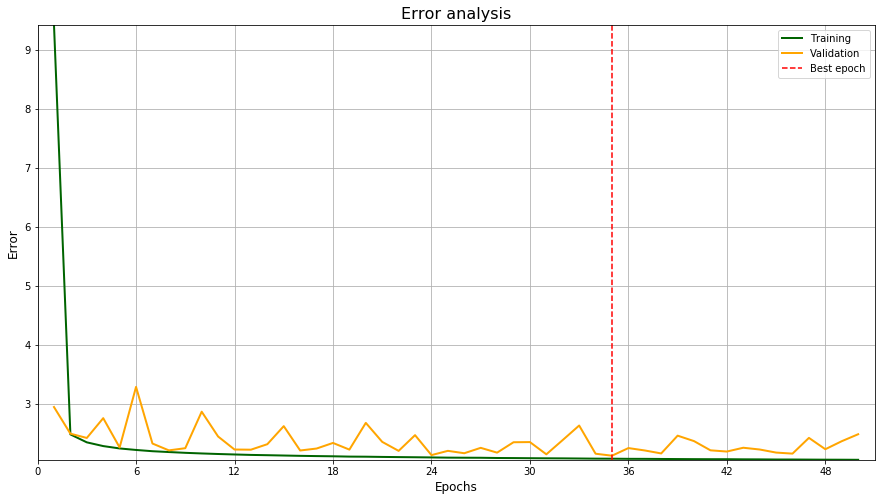

In [16]:
util.save_loss(train_losses, val_losses)
util.plot([train_losses, val_losses], ['Training', 'Validation'], 
          'Epochs', 'Error', 'Error analysis', inline=True)

In [17]:
model,_, best_epoch, val_loss = trainer.load_checkpoint(checkpoint_filename)

=> Loaded checkpoint cfsr_1_20190929-205215.pth.tar (best epoch: 35, validation error: 2.1235)


Evaluating the model

In [18]:
evaluator = Evaluator(model, criterion, test_loader, device)
test_loss = evaluator.eval()
loss_type = type(criterion).__name__
print(f'ConvLSTM {loss_type}: {test_loss:.4f}')

ConvLSTM RMSELoss: 2.0986


In [19]:
if (torch.cuda.is_available()):
    torch.cuda.empty_cache()

Notification via email

In [21]:
model_info = {'Jupyter': 'yes',
              'best_epoch': best_epoch,
              'val_error': val_loss,
              'test_error': test_loss,
              'loss_type': loss_type,
              'step': step,
              'layer': layer_size,
              'kernel_size': kernel_size,
              'filter': hidden_dim,
              'dataset': dataset,
              'hostname': platform.node()}

In [22]:
util.send_email(model_info)

6642.230965614319
email sent
